# [ASHRAE - Great Energy Predictor III](https://www.kaggle.com/c/ashrae-energy-prediction/overview)

How much energy will a building consume?


---

Developing energy savings has two key elements: Forecasting future energy usage without improvements, and forecasting energy use after a specific set of improvements have been implemented, like the installation and purchase of investment-grade meters, whose prices continue to fall. One issue preventing more aggressive growth of the energy markets are the lack of cost-effective, accurate, and scalable procedures for forecasting energy use.

**In this competition, you’ll develop accurate predictions of metered building energy usage in the following areas: chilled water, electric, natural gas, hot water, and steam meters. The data comes from over 1,000 buildings over a three-year timeframe.**

With better estimates of these energy-saving investments, large scale investors and financial institutions will be more inclined to invest in this area to enable progress in building efficiencies.

In [1]:
# standard libraries
import pandas as pd
pd.set_option('display.max_columns', None) 
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import os

In [3]:
os.listdir('../../kaggle download/ashrae-energy-prediction')

['building_metadata.csv',
 'sample_submission.csv',
 'test.csv',
 'train.csv',
 'weather_test.csv',
 'weather_train.csv']

In [4]:
%%time
# read primary training data and test data
train = pd.read_csv('../../kaggle download/ashrae-energy-prediction/train.csv')
test = pd.read_csv('../../kaggle download/ashrae-energy-prediction/test.csv')

# read complimentary datasets
weather_train = pd.read_csv('../../kaggle download/ashrae-energy-prediction/weather_train.csv')
weather_test = pd.read_csv('../../kaggle download/ashrae-energy-prediction/weather_test.csv')
building_metadata = pd.read_csv('../../kaggle download/ashrae-energy-prediction/building_metadata.csv')

CPU times: user 51.7 s, sys: 12 s, total: 1min 3s
Wall time: 1min 7s


In [15]:
# Glimpse of data
print('Size of train data', train.shape)
print('Size of test data', test.shape)
print('Size of building_metadata', building_metadata.shape)
print('Size of weather_train data', weather_train.shape)
print('Size of weather_test data', weather_test.shape)

Size of train data (20216100, 4)
Size of test data (41697600, 4)
Size of building_metadata (1449, 6)
Size of weather_train data (139773, 9)
Size of weather_test data (277243, 9)


In [7]:
train.memory_usage()

Index                   80
building_id      161728800
meter            161728800
timestamp        161728800
meter_reading    161728800
dtype: int64

In [20]:
test.memory_usage()

Index                 80
row_id         166790400
building_id     83395200
meter           41697600
timestamp      333580800
dtype: int64

In [8]:
# Reduce Memory Size
def reduce_mem_usage(df, verbose=True):
    num_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in num_types:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

building_metadata = reduce_mem_usage(building_metadata)
weather_train = reduce_mem_usage(weather_train)
weather_test = reduce_mem_usage(weather_test)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)


In [9]:
train.dtypes

building_id               int16
meter                      int8
timestamp        datetime64[ns]
meter_reading           float32
dtype: object

In [5]:
# Convert `timestamp` col to datetime type

%%time
def timestampColType(df, tablename='Unknown'):
    try:
        df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
        print(f'datetime converted for {tablename}')
    except:
        print(f'\'timestamp\' column may not exist in {tablename}')

timestampColType(train, 'train')
timestampColType(test, 'test')
timestampColType(building_metadata, 'building_meta')
timestampColType(weather_train, 'weather_train')
timestampColType(weather_test, 'weather_test')

datetime converted for train
datetime converted for test
'timestamp' column may not exist in building_meta
datetime converted for weather_train
datetime converted for weather_test
CPU times: user 19.9 s, sys: 1.62 s, total: 21.5 s
Wall time: 21.6 s


In [6]:
train.dtypes

building_id               int64
meter                     int64
timestamp        datetime64[ns]
meter_reading           float64
dtype: object

> ### training dataset has 20M rows, and test dataset has ~42M rows

## Target column distribution

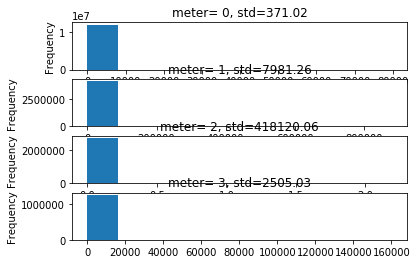

In [94]:
# Univariate
#fig, ax = plt.subplot(4, 1)
for meter, readings in train.groupby('meter')['meter_reading']:
    plt.subplot(4, 1, meter+1)
    plt.title(f'meter= {meter}, std={round(readings.std(), 2)}')
    readings.plot(kind='hist')

#plt.show()

> ### Variance is too high

Sample a building with ID 1374 , meter = 1


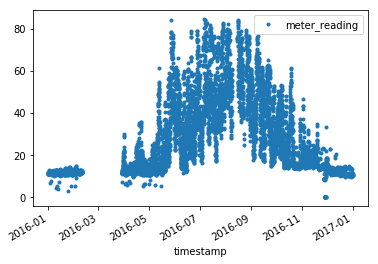

In [66]:
# vs. timestamp (fixing building & meter)

import random
random.seed(1010)
BUILD_ID = random.randint(0, 1448)
METER = random.randint(0, 3)

print('Sample a building with ID', BUILD_ID, ', meter =', METER)

sample_train = train.loc[(train['building_id']==BUILD_ID) & (train['meter']==METER)]
sample_train.plot('timestamp', 'meter_reading', style='.')

By obversing the above plot, it can be easily seen that missing data around 2016-03, but it is hard to discover all missing data.

In [68]:
train.isnull().sum()

building_id      0
meter            0
timestamp        0
meter_reading    0
dtype: int64

In [98]:
train.loc[train['meter_reading']==0, 'meter_reading']= np.nan

In [102]:
reading_summary = train.groupby(['meter', 'building_id'])['meter_reading'].agg(['mean', 'std'])

In [103]:
type(reading_summary)

pandas.core.frame.DataFrame

In [107]:
reading_summary.columns

Index(['mean', 'std'], dtype='object')

In [108]:
reading_summary

mean          std
meter building_id                          
0     0             237.749130    49.132168
      1             118.553741    29.347374
      2              23.626499    14.302269
      3             382.736023   112.268532
      4            1579.174194   176.969437
      5              28.963480    15.861161
      6             104.080093    34.478031
      7             569.244446    99.735390
      8             417.394836    61.751499
      9             118.129517    43.559811
      10           1593.610474   364.506348
      11            475.006744    48.278217
      12            228.897827    59.546719
      13            370.414276    75.846298
      14            421.637878   104.628853
      15            267.903442    68.938965
      16           1297.286011   250.026474
      17            105.277275    32.351418
      18           2027.562744   129.072708
      19            205.310486    37.185703
      20            515.986084   134.327713
      21             76.813835    28.510511
      22             29.949657     9.008471
      23            885.075439   105.035782
      24            889.027405   186.476639
      25            358.178009   142.708298
      26            163.225616    66.405548
      27            277.329559    57.668686
      28            248.247147    69.408493
      29           1006.366272   282.904633
...                        ...          ...
3     1267          743.296936   352.712280
      1268          322.989227   305.302612
      1269          395.133911   290.934235
      1270          279.062531   197.821274
      1271          238.323288   130.476913
      1272         1382.758423   671.156372
      1273          658.715881   283.617889
      1274          167.184525   141.135910
      1275          707.675964   408.896515
      1276          333.859711   192.904755
      1293          667.059143   251.285828
      1294           44.660622    62.332817
      1295          330.127289   460.758575
      1296           25.217026    35.195400
      1297           61.270298    85.514931
      1298          428.893982   540.372253
      1300           73.085426   102.005287
      1301          113.203003   222.598770
      1302         1168.902588  1214.198730
      1311          112.835594   147.824478
      1312          220.710770   181.399048
      1317         1311.386841   530.703247
      1318          402.470673   312.551971
      1319          523.017395   406.166534
      1321          889.852417   810.146240
      1322         1101.194092   924.056885
      1323         1356.687378   572.857178
      1324          350.714447   331.347321
      1325          275.431793   174.215378
      1331         5534.906738  4832.971680

[2380 rows x 2 columns]

In [139]:
reading_summary.index.get_level_values(0)

Int64Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            ...
            3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
           dtype='int64', name='meter', length=2380)

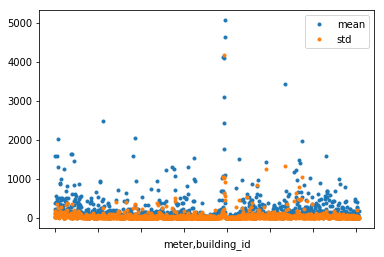

In [145]:
reading_summary.iloc[reading_summary.index.get_level_values(0)==0, :].plot(style='.')

meter = 0
meter = 1
meter = 2
meter = 3


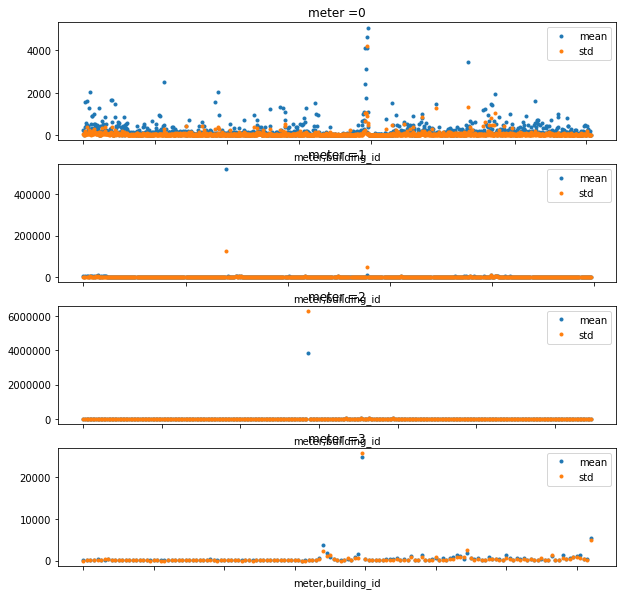

In [169]:
fig, axs = plt.subplots(4)

for meter in range(4):dd
    reading_summary.iloc[reading_summary.index.get_level_values(0)==meter, :].plot(style='.', ax=axs[meter], figsize=(10, 10), title=f'meter ={meter}')

## Missing data or zeros

In [19]:
train['timestamp'].unique(), train['timestamp'].nunique()

(array(['2016-01-01 00:00:00', '2016-01-01 01:00:00',
        '2016-01-01 02:00:00', ..., '2016-12-31 21:00:00',
        '2016-12-31 22:00:00', '2016-12-31 23:00:00'], dtype=object), 8784)

In [12]:
train.describe()

,building_id,meter,meter_reading
count,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,2.117121e+03
std,4.269133e+02,9.309921e-01,1.532356e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01
50%,8.950000e+02,0.000000e+00,7.877500e+01
75%,1.179000e+03,1.000000e+00,2.679840e+02
max,1.448000e+03,3.000000e+00,2.190470e+07


In [20]:
train.dtypes

building_id        int64
meter              int64
timestamp         object
meter_reading    float64
dtype: object

In [26]:
def ChangeColType(df):
    df['building_id'] = df['building_id'].astype(str)
    df['meter'] = df['meter'].astype(str)
    df['timestamp'] = pd.to_datetime(df['timestamp'])

In [27]:
ChangeColType(train)
ChangeColType(test)

In [33]:
train.dtypes

building_id              object
meter                    object
timestamp        datetime64[ns]
meter_reading           float64
dtype: object

In [34]:
train['timestamp'].head()

0   2016-01-01
1   2016-01-01
2   2016-01-01
3   2016-01-01
4   2016-01-01
Name: timestamp, dtype: datetime64[ns]

In [ ]:
train.isnull().sum()

## Building

In [76]:
building_metadata.shape # each building has one row

(1449, 6)

In [72]:
building_metadata.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [73]:
building_metadata.describe(include='all')

,site_id,building_id,primary_use,square_feet,year_built,floor_count
count,1449.000000,1449.000000,1449,1449.000000,675.000000,355.000000
unique,NaN,NaN,16,NaN,NaN,NaN
top,NaN,NaN,Education,NaN,NaN,NaN
freq,NaN,NaN,549,NaN,NaN,NaN
mean,6.952381,724.000000,NaN,92111.776398,inf,3.740234
std,5.003432,418.434583,NaN,110769.950997,31.062500,3.333984
min,0.000000,0.000000,NaN,283.000000,1900.000000,1.000000
25%,3.000000,362.000000,NaN,23012.000000,1949.000000,1.000000
50%,5.000000,724.000000,NaN,57673.000000,1970.000000,3.000000
75%,13.000000,1086.000000,NaN,115676.000000,1995.000000,5.000000


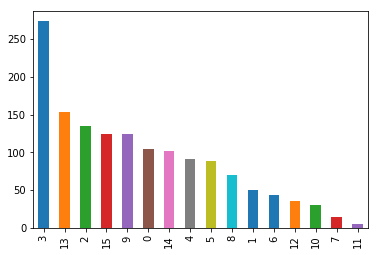

In [172]:
building_metadata.site_id.value_counts().plot(kind='bar')

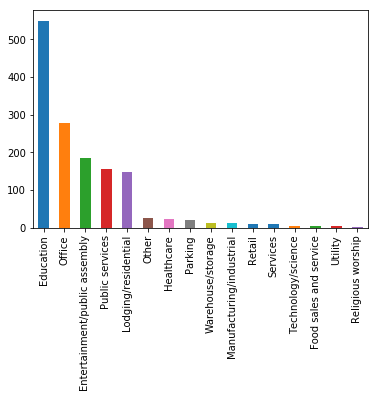

In [173]:
building_metadata.primary_use.value_counts().plot(kind='bar')

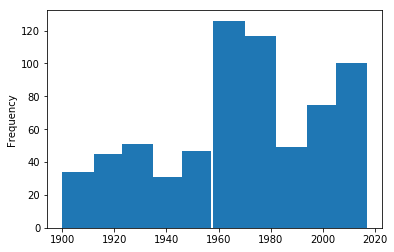

In [176]:
building_metadata.year_built.plot(kind='hist')

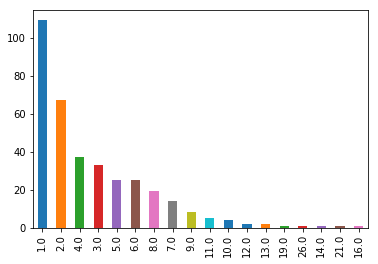

In [177]:
building_metadata.floor_count.value_counts().plot(kind='bar')

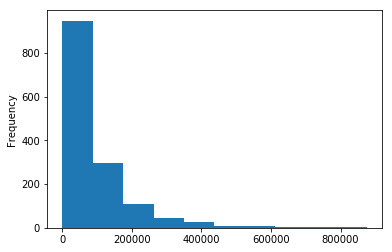

In [178]:
building_metadata.square_feet.plot(kind='hist')

## Weather

In [77]:
weather_train.shape

(139773, 9)

In [78]:
weather_train['timestamp'].describe()

count                  139773
unique                   8784
top       2016-11-04 05:00:00
freq                       16
first     2016-01-01 00:00:00
last      2016-12-31 23:00:00
Name: timestamp, dtype: object

In [80]:
time_diff = weather_train['timestamp'].max() - weather_train['timestamp'].min()


In [88]:
time_diff.total_seconds()/60**2

8783.0

In [74]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609


In [75]:
weather_train.describe()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,139773.000000,139718.000000,70600.0,139660.000000,89484.0,129155.0,133505.0,139469.000000
mean,7.478977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.604744,0.000000,0.0,0.000000,NaN,NaN,NaN,0.000000
min,0.000000,-28.906250,0.0,-35.000000,-1.0,968.0,0.0,0.000000
25%,3.000000,7.199219,0.0,0.600098,0.0,1012.0,80.0,2.099609
50%,7.000000,15.000000,2.0,8.296875,0.0,1016.5,190.0,3.099609
75%,11.000000,22.203125,4.0,14.398438,0.0,1021.0,280.0,5.000000
max,15.000000,47.187500,9.0,26.093750,343.0,1046.0,360.0,19.000000


In [180]:
weather_train.groupby(['site_id'])['timestamp'].count()

site_id
0     8784
1     8763
2     8783
3     8780
4     8783
5     8755
6     8782
7     8614
8     8784
9     8780
10    8782
11    8614
12    8755
13    8783
14    8777
15    8454
Name: timestamp, dtype: int64